In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs 
from sklearn.tree import DecisionTreeClassifier, export_text

In [2]:
from sklearn.datasets import make_blobs 

# make data
X, y = make_blobs(
    n_samples=100,
    n_features=2,
    centers=4,
    cluster_std=[1, 2, 1, 3],
    random_state=42,
)

# Make it binary
y = [val % 2 for val in y]

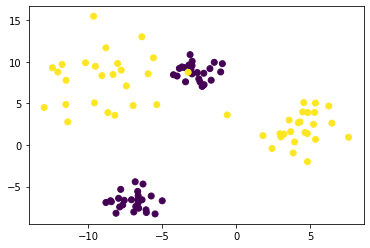

In [3]:
fig, ax = plt.subplots(1)

ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y
)

plt.show()

In [4]:
DEPTH = 3

model = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
model.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [5]:
tree_rules = export_text(model, feature_names=['x0', 'x1'])
print(tree_rules)

|--- x0 <= -0.76
|   |--- x0 <= -8.80
|   |   |--- class: 1
|   |--- x0 >  -8.80
|   |   |--- x1 <= -0.42
|   |   |   |--- class: 0
|   |   |--- x1 >  -0.42
|   |   |   |--- class: 0
|--- x0 >  -0.76
|   |--- class: 1



In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [7]:
clf = model

In [8]:
# Gathering relevant methods
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
values = clf.tree_.value

# Determening tree structure
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

tree_dict = {}
tree_dict['depth'] = 5
tree_dict['nodes'] = [{} for _ in range(n_nodes)]

for i in range(n_nodes):
    if is_leaves[i]:
        tree_dict['nodes'][i]['is_leaf'] = 1
        tree_dict['nodes'][i]['depth'] = node_depth[i]
        tree_dict['nodes'][i]['index'] = i
        tree_dict['nodes'][i]['class'] = np.argmax(values[i])
    else:
        tree_dict['nodes'][i]['is_leaf'] = 0
        tree_dict['nodes'][i]['depth'] = node_depth[i]
        tree_dict['nodes'][i]['index'] = i
        tree_dict['nodes'][i]['class'] = np.argmax(values[i])
        tree_dict['nodes'][i]['left'] = children_left[i]
        tree_dict['nodes'][i]['right'] = children_right[i]
        tree_dict['nodes'][i]['feature'] = feature[i]
        tree_dict['nodes'][i]['threshold'] = threshold[i]
        
    tree_dict['nodes'][i]['population'] = []

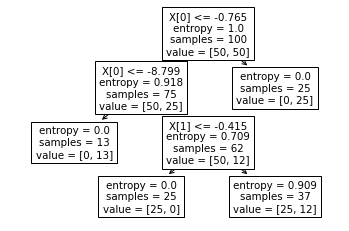

In [9]:
tree.plot_tree(clf)
plt.show()

In [10]:
for t, v in zip(threshold, feature):
    print(t, v)

-0.764798104763031 0
-8.7988600730896 0
-2.0 -2
-0.4152803421020508 1
-2.0 -2
-2.0 -2
-2.0 -2


In [11]:
tree_dict['nodes'][2]

{'is_leaf': 1, 'depth': 2, 'index': 2, 'class': 1, 'population': []}

In [12]:
tree_dict['links'] = []

x_min = X[:,0].min()
x_max = X[:,0].max()
y_min = X[:,1].min()
y_max = X[:,1].max()

# Global collection of hyperplanes
tree_dict['hyperplanes'] = []
tree_dict['regions'] = []

def get_coordinates(i, pos_x, pos_y, hyperplanes, regions):
    '''DOCSTRING'''
    pos_y = tree_dict['nodes'][i]['depth'] * 10
    
    tree_dict['nodes'][i]['pos_x'] = pos_x
    tree_dict['nodes'][i]['pos_y'] = pos_y
    tree_dict['nodes'][i]['hyperplanes'] = hyperplanes
    
    if tree_dict['nodes'][i]['is_leaf'] == 1:
        tree_dict['regions'] += regions
        tree_dict['regions'][-1]['type'] = 'leaf_' + str(tree_dict['nodes'][i]['class'])
        tree_dict['nodes'][i]['regions'] = regions
        tree_dict['nodes'][i]['regions'][-1]['type'] = 'leaf_' + str(tree_dict['nodes'][i]['class'])
        return
    
    thresh = tree_dict['nodes'][i]['threshold']
    
    # Calculates current hyperplane
    current_hyperplane = {}
    current_regions = []
    if tree_dict['nodes'][i]['feature'] == 0:
        current_hyperplane['x1'] = thresh
        current_hyperplane['x2'] = thresh
        
        current_hyperplane['y1'] = y_min
        current_hyperplane['y2'] = y_max
        
        for region in regions:
            # left region
            current_regions.append(
                {
                    'x': region['x'],
                    'y': region['y'],
                    'width': thresh - region['x'],
                    'height': region['height'],
                    'type': 'left_child_region',
                }
            )
            # right region
            current_regions.append(
                {
                    'x': thresh,
                    'y': region['y'],
                    'width': region['width'] - (thresh - region['x']),
                    'height': region['height'],
                    'type': 'right_child_region',
                }
            )
    else:
        current_hyperplane['x1'] = x_min
        current_hyperplane['x2'] = x_max
        
        current_hyperplane['y1'] = thresh
        current_hyperplane['y2'] = thresh
        
        for region in regions:
            # upper region
            current_regions.append(
                {
                    'x': region['x'],
                    'y': thresh,
                    'width': region['width'],
                    'height': thresh - (region['y'] - region['height']),
                    'type': 'right_child_region',
                }
            )
            
            # lower region
            current_regions.append(
                {
                    'x': region['x'],
                    'y': region['y'],
                    'width': region['width'],
                    'height': region['y'] - thresh,
                    'type': 'left_child_region',
                }
            )

    tree_dict['nodes'][i]['hyperplanes'].append(current_hyperplane)
    tree_dict['nodes'][i]['regions'] = current_regions
    
    tree_dict['hyperplanes'].append(current_hyperplane)
    
    # We will only keep the terminal regions in the tree data, so we will only
    # add the regions of the leaf nodes
    
    # Save left link
    tree_dict['links'].append({})
    tree_dict['links'][-1]['x1'] = pos_x
    tree_dict['links'][-1]['y1'] = pos_y
    tree_dict['links'][-1]['x2'] = pos_x + 10 + (2 * depth)
    tree_dict['links'][-1]['y2'] = pos_y + 10
    
    # Save right link
    tree_dict['links'].append({})
    tree_dict['links'][-1]['x1'] = pos_x
    tree_dict['links'][-1]['y1'] = pos_y
    tree_dict['links'][-1]['x2'] = pos_x - 10 - (2 * depth)
    tree_dict['links'][-1]['y2'] = pos_y + 10
    
    get_coordinates(
        tree_dict['nodes'][i]['left'],
        pos_x + 10 + (2 * depth),
        pos_y,
        tree_dict['nodes'][i]['hyperplanes'].copy(),
        [current_regions[0].copy()],
    )
    
    get_coordinates(
        tree_dict['nodes'][i]['right'],
        pos_x - 10 - (2 * depth),
        pos_y,
        tree_dict['nodes'][i]['hyperplanes'].copy(),
        [current_regions[1].copy()],
    )
    


In [13]:
full_region = [{
    'x': x_min, 
    'y': y_max,
    'width': x_max - x_min,
    'height': y_max - y_min,
    'type': 'full_region',
}]

In [14]:
full_region

[{'x': -12.971335860507283,
  'y': 15.48403041526756,
  'width': 20.567002786218417,
  'height': 23.765991071335787,
  'type': 'full_region'}]

In [15]:
get_coordinates(0, 0, 0, [], full_region)

In [16]:
print(x_min)
print(x_max)
print(y_min)
print(y_max)

-12.971335860507283
7.595666925711134
-8.281960656068227
15.48403041526756


In [17]:
tree_dict['regions']

[{'x': -12.971335860507283,
  'y': 15.48403041526756,
  'width': 4.172475787417683,
  'height': 23.765991071335787,
  'type': 'leaf_1'},
 {'x': -8.7988600730896,
  'y': -0.4152803421020508,
  'width': 8.034061968326569,
  'height': 7.866680313966176,
  'type': 'leaf_0'},
 {'x': -8.7988600730896,
  'y': 15.48403041526756,
  'width': 8.034061968326569,
  'height': 15.89931075736961,
  'type': 'leaf_0'},
 {'x': -0.764798104763031,
  'y': 15.48403041526756,
  'width': 8.360465030474165,
  'height': 23.765991071335787,
  'type': 'leaf_1'}]

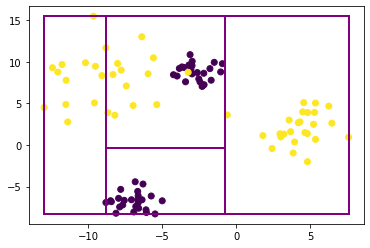

In [18]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1)

ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y
)

for rect in tree_dict['regions']:
    left=rect['x']
    bottom=rect['y'] - rect['height']
    width=rect['width']
    height=rect['height']
    rect=mpatches.Rectangle((left,bottom),width,height, 
                            fill=False,
                            color="purple",
                           linewidth=2)
                           #facecolor="red")
    plt.gca().add_patch(rect)
plt.show()

In [19]:
tree_dict['nodes'][4]

{'is_leaf': 1,
 'depth': 3,
 'index': 4,
 'class': 0,
 'population': [],
 'pos_x': 14,
 'pos_y': 30,
 'hyperplanes': [{'x1': -0.764798104763031,
   'x2': -0.764798104763031,
   'y1': -8.281960656068227,
   'y2': 15.48403041526756},
  {'x1': -8.7988600730896,
   'x2': -8.7988600730896,
   'y1': -8.281960656068227,
   'y2': 15.48403041526756},
  {'x1': -12.971335860507283,
   'x2': 7.595666925711134,
   'y1': -0.4152803421020508,
   'y2': -0.4152803421020508}],
 'regions': [{'x': -8.7988600730896,
   'y': -0.4152803421020508,
   'width': 8.034061968326569,
   'height': 7.866680313966176,
   'type': 'leaf_0'}]}

In [20]:
tree_dict['links']

[{'x1': 0, 'y1': 0, 'x2': 14, 'y2': 10},
 {'x1': 0, 'y1': 0, 'x2': -14, 'y2': 10},
 {'x1': 14, 'y1': 10, 'x2': 28, 'y2': 20},
 {'x1': 14, 'y1': 10, 'x2': 0, 'y2': 20},
 {'x1': 0, 'y1': 20, 'x2': 14, 'y2': 30},
 {'x1': 0, 'y1': 20, 'x2': -14, 'y2': 30}]

In [21]:
tree_dict['hyperplanes']

[{'x1': -0.764798104763031,
  'x2': -0.764798104763031,
  'y1': -8.281960656068227,
  'y2': 15.48403041526756},
 {'x1': -8.7988600730896,
  'x2': -8.7988600730896,
  'y1': -8.281960656068227,
  'y2': 15.48403041526756},
 {'x1': -12.971335860507283,
  'x2': 7.595666925711134,
  'y1': -0.4152803421020508,
  'y2': -0.4152803421020508}]

In [22]:
node_indicator = clf.decision_path(X)
leaf_id = clf.apply(X)

In [23]:
sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

In [24]:
node_index

array([0, 1, 2], dtype=int32)

In [25]:
print('Rules used to predict sample {id}:\n'.format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        print(f'leaf {node_id}')
        continue

    # check if value of the split feature for sample 0 is below threshold
    if (X[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature[node_id],
              value=X[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id]))


Rules used to predict sample 0:

decision node 0 : (X[0, 0] = -11.378708910841226) <= -0.764798104763031)
decision node 1 : (X[0, 0] = -11.378708910841226) <= -8.7988600730896)
leaf 2


In [26]:
for sample_id in range(len(X)):
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]
    for node_id in node_index:
        tree_dict['nodes'][node_id]['population'].append(sample_id)

In [27]:
y_pred = model.predict(X)

In [28]:
df = pd.DataFrame(
        zip(X[:, 0], X[:, 1], y, y_pred),
        columns=['x0', 'x1', 'y', 'pred']
)
df['index'] = df.index

In [29]:
tree_dict['hyperplanes']

[{'x1': -0.764798104763031,
  'x2': -0.764798104763031,
  'y1': -8.281960656068227,
  'y2': 15.48403041526756},
 {'x1': -8.7988600730896,
  'x2': -8.7988600730896,
  'y1': -8.281960656068227,
  'y2': 15.48403041526756},
 {'x1': -12.971335860507283,
  'x2': 7.595666925711134,
  'y1': -0.4152803421020508,
  'y2': -0.4152803421020508}]

In [30]:


df.to_csv('example_data.csv', index=False, header=True)


In [31]:
tree_dict['data'] = df.to_dict('records')

import json

# https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable/50916741
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)
        
with open('tree.json', 'w') as fp:
    json.dump(tree_dict, fp, cls=NpEncoder)

In [32]:
for i in range(n_nodes):
    print(tree_dict['nodes'][i]['pos_y'])

0
10
20
20
30
30
10


In [33]:
n_nodes

7

In [34]:
len(tree_dict['nodes'])

7

In [35]:
for i in range(n_nodes):
    print(tree_dict['nodes'][i]['pos_x'])

0
14
28
0
14
-14
-14


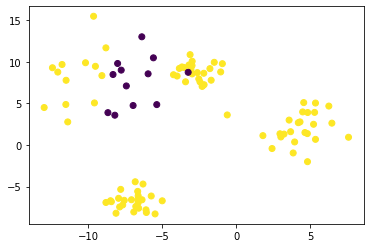

In [36]:
df['correct'] = (df['y'] == df['pred'])

fig, ax = plt.subplots(1)

ax.scatter(
    df['x0'],
    df['x1'],
    c=df['correct']
)

plt.show()

In [73]:
df.correct.sum() / len(df)

0.88

In [74]:
# make data
X, y = make_blobs(
    n_samples=30,
    n_features=2,
    centers=2,
    cluster_std=[2, 2],
    random_state=102,
)

# Make it binary
y = [val % 2 for val in y]

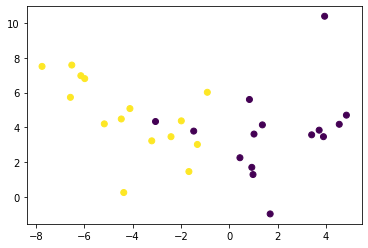

In [75]:
fig, ax = plt.subplots(1)

ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y
)

plt.show()

In [24]:
from itertools import accumulate

In [180]:
def get_splits(arr):
    outs = []
    for i in range(len(arr)):
        outs.append((arr[i-1] + arr[i])/ 2)
    return outs

splits = get_splits(sorted(X[:, 0]))

In [181]:
splits.pop(0)

-1.4496366862707166

In [182]:
splits

[-7.161476868257987,
 -6.5456042399258365,
 -6.329552156004855,
 -6.061913215721406,
 -5.576589617698907,
 -4.820225598512265,
 -4.417843357521466,
 -4.238954009337262,
 -3.659388865566333,
 -3.1297995706620227,
 -2.7311872968248334,
 -2.1973801933880224,
 -1.82708503911428,
 -1.570341982175725,
 -1.3950100062566035,
 -1.1133520283791976,
 -0.23258871146911397,
 0.6390412508087285,
 0.884811965847648,
 0.9588589772943371,
 1.004259956123519,
 1.198135251203622,
 1.5325628675520517,
 2.55236573227978,
 3.566416990176452,
 3.810831464759864,
 3.923986262229258,
 4.250569847063031,
 4.701278875822357]

In [183]:
print(get_splits([1,2,3,4,5]))

[3.0, 1.5, 2.5, 3.5, 4.5]


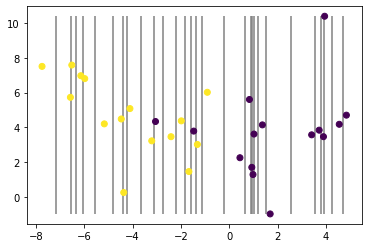

In [184]:
fig, ax = plt.subplots(1)

ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y
)

ax.vlines(list(splits), min(X[:, 1]), max(X[:, 1]), zorder=-1, color='gray')

plt.show()

In [185]:
df = pd.DataFrame(
        zip(X[:, 0], X[:, 1], y),
        columns=['x0', 'x1', 'y']
)

In [186]:
df.x1.max()

10.376863955182255

In [187]:
df.x1.min()

-0.9566688951135047

In [188]:
df.shape

(30, 3)

In [189]:
from scipy.stats import entropy

In [190]:
[sum(y), len(y) - sum(y)]

[15, 15]

In [191]:
St = entropy([sum(y), len(y) - sum(y)], base=2)

In [192]:
St

1.0

In [193]:
gains = {}
gains['splits'] = []

for split in splits:
    gains['splits'].append({})
    gains['splits'][-1]['value'] = split
    
    pop_left = df[df.x0 <= split]
    pop_right = df[df.x0 > split]
    
    gains['splits'][-1]['gain'] = St 
    gains['splits'][-1]['gain'] -= len(pop_left) * entropy(
        [pop_left.y.sum(), len(pop_left.y) - pop_left.y.sum()],
    )
    gains['splits'][-1]['gain'] -= len(pop_right) * entropy(
        [pop_right.y.sum(), len(pop_right.y) - pop_right.y.sum()],
    )

In [194]:
gains

{'splits': [{'value': -7.161476868257987, 'gain': -19.084023438460974},
  {'value': -6.5456042399258365, 'gain': -18.336631621372582},
  {'value': -6.329552156004855, 'gain': -17.54796256812773},
  {'value': -6.061913215721406, 'gain': -16.712908971243305},
  {'value': -5.576589617698907, 'gain': -15.825291675231412},
  {'value': -4.820225598512265, 'gain': -14.877517715791571},
  {'value': -4.417843357521466, 'gain': -13.860081616398604},
  {'value': -4.238954009337262, 'gain': -12.760809913962607},
  {'value': -3.659388865566333, 'gain': -11.563661360290402},
  {'value': -3.1297995706620227, 'gain': -10.246702892376167},
  {'value': -2.7311872968248334, 'gain': -13.301345498219867},
  {'value': -2.1973801933880224, 'gain': -11.97674337971171},
  {'value': -1.82708503911428, 'gain': -10.447449217881697},
  {'value': -1.570341982175725, 'gain': -8.63078354771663},
  {'value': -1.3950100062566035, 'gain': -10.780234016826565},
  {'value': -1.1133520283791976, 'gain': -8.63078354771663},

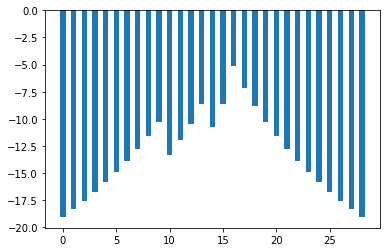

In [197]:
fig, ax  = plt.subplots(1)

positions = list(range(len(gains['splits'])))
values = []
for item in gains['splits']:
    values.append(item['gain'])

ax.bar(positions, values, width=0.5)

plt.show()

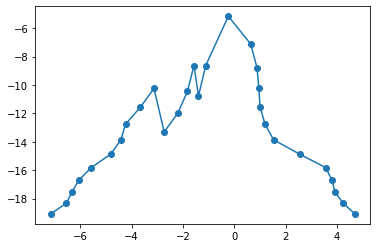

In [199]:
fig, ax  = plt.subplots(1)

# positions = list(range(len(gains)))
positions = []
for item in gains['splits']:
    positions.append(item['value'])
values = []
for item in gains['splits']:
    values.append(item['gain'])

ax.plot(
    positions,
    values,
    marker='o'
)

plt.show()

In [200]:
gains['data'] = df.to_dict('records')

In [201]:
gains

{'splits': [{'value': -7.161476868257987, 'gain': -19.084023438460974},
  {'value': -6.5456042399258365, 'gain': -18.336631621372582},
  {'value': -6.329552156004855, 'gain': -17.54796256812773},
  {'value': -6.061913215721406, 'gain': -16.712908971243305},
  {'value': -5.576589617698907, 'gain': -15.825291675231412},
  {'value': -4.820225598512265, 'gain': -14.877517715791571},
  {'value': -4.417843357521466, 'gain': -13.860081616398604},
  {'value': -4.238954009337262, 'gain': -12.760809913962607},
  {'value': -3.659388865566333, 'gain': -11.563661360290402},
  {'value': -3.1297995706620227, 'gain': -10.246702892376167},
  {'value': -2.7311872968248334, 'gain': -13.301345498219867},
  {'value': -2.1973801933880224, 'gain': -11.97674337971171},
  {'value': -1.82708503911428, 'gain': -10.447449217881697},
  {'value': -1.570341982175725, 'gain': -8.63078354771663},
  {'value': -1.3950100062566035, 'gain': -10.780234016826565},
  {'value': -1.1133520283791976, 'gain': -8.63078354771663},

In [202]:
import json

# https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable/50916741
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)
        
with open('split_gains.json', 'w') as fp:
    json.dump(gains, fp, cls=NpEncoder)

In [2]:
2 ** 4

16

In [110]:
from collections import defaultdict

tree = {}
tree['points'] = []
tree['links'] = []

start = 0
end = 10
previous_positions = None

for level in list(range(5))[::-1]:
    n_points = (2 ** (level + 1)) + 1
    step = (end - start) / (n_points - 1)
    positions = [start + i * step for i in range(n_points)]
    used_positions = []
    for i, val in enumerate(positions):
        if (i % 2 == 0):
            continue
        tree['points'].append({})
        used_positions.append(val)
        
        tree['points'][-1]['x'] = val 
        tree['points'][-1]['y'] = 4 - level
        tree['points'][-1]['value'] = 10 * np.random.random() + (5 - level)
        tree['points'][-1]['variable'] = np.random.choice(np.array([0, 1]))
        if previous_positions is not None:
            pos = len(used_positions) - 1
            tree['links'].append({})
            tree['links'][-1]['x1'] = val
            tree['links'][-1]['x2'] = previous_positions[2 * pos]
            tree['links'][-1]['y1'] = 4 - level
            tree['links'][-1]['y2'] = (4 - level) - 1
            tree['links'].append({})
            tree['links'][-1]['x1'] = val
            tree['links'][-1]['x2'] = previous_positions[(2 * pos) + 1]
            tree['links'][-1]['y1'] = 4 - level
            tree['links'][-1]['y2'] = (4 - level) - 1
            
    previous_positions = used_positions


In [2]:
tree = {'points': [{'x': 0.3125, 'y': 0, 'value': 8.604394186997094, 'variable': 0},
  {'x': 0.9375, 'y': 0, 'value': 10.435935770241692, 'variable': 0},
  {'x': 1.5625, 'y': 0, 'value': 3.588824160668688, 'variable': 0},
  {'x': 2.1875, 'y': 0, 'value': 9.952075501156154, 'variable': 1},
  {'x': 2.8125, 'y': 0, 'value': 10.104013750950099, 'variable': 0},
  {'x': 3.4375, 'y': 0, 'value': 10.070414752120197, 'variable': 0},
  {'x': 4.0625, 'y': 0, 'value': 6.010510715780533, 'variable': 0},
  {'x': 4.6875, 'y': 0, 'value': 9.948888366153687, 'variable': 0},
  {'x': 5.3125, 'y': 0, 'value': 9.249372318751993, 'variable': 0},
  {'x': 5.9375, 'y': 0, 'value': 10.810512814352965, 'variable': 1},
  {'x': 6.5625, 'y': 0, 'value': 4.778802720990813, 'variable': 0},
  {'x': 7.1875, 'y': 0, 'value': 3.0323302873368365, 'variable': 0},
  {'x': 7.8125, 'y': 0, 'value': 6.772675981853499, 'variable': 0},
  {'x': 8.4375, 'y': 0, 'value': 9.09019690684594, 'variable': 1},
  {'x': 9.0625, 'y': 0, 'value': 2.6511823827901106, 'variable': 0},
  {'x': 9.6875, 'y': 0, 'value': 10.84895420846731, 'variable': 1},
  {'x': 0.625, 'y': 1, 'value': 6.209570423699916, 'variable': 1},
  {'x': 1.875, 'y': 1, 'value': 5.382249297929214, 'variable': 0},
  {'x': 3.125, 'y': 1, 'value': 7.213343782904882, 'variable': 0},
  {'x': 4.375, 'y': 1, 'value': 6.95359966346709, 'variable': 1},
  {'x': 5.625, 'y': 1, 'value': 3.8711036214673915, 'variable': 1},
  {'x': 6.875, 'y': 1, 'value': 7.652112350562794, 'variable': 1},
  {'x': 8.125, 'y': 1, 'value': 8.305268744431118, 'variable': 0},
  {'x': 9.375, 'y': 1, 'value': 11.072034453896096, 'variable': 1},
  {'x': 1.25, 'y': 2, 'value': 9.883599258244658, 'variable': 0},
  {'x': 3.75, 'y': 2, 'value': 5.84150461329126, 'variable': 1},
  {'x': 6.25, 'y': 2, 'value': 4.948094350681444, 'variable': 0},
  {'x': 8.75, 'y': 2, 'value': 10.172943824167291, 'variable': 0},
  {'x': 2.5, 'y': 3, 'value': 6.735297328417683, 'variable': 0},
  {'x': 7.5, 'y': 3, 'value': 5.50867856494105, 'variable': 0},
  {'x': 5.0, 'y': 4, 'value': 9.578376205019406, 'variable': 0}],
 'links': [{'x1': 0.625, 'x2': 0.3125, 'y1': 1, 'y2': 0},
  {'x1': 0.625, 'x2': 0.9375, 'y1': 1, 'y2': 0},
  {'x1': 1.875, 'x2': 1.5625, 'y1': 1, 'y2': 0},
  {'x1': 1.875, 'x2': 2.1875, 'y1': 1, 'y2': 0},
  {'x1': 3.125, 'x2': 2.8125, 'y1': 1, 'y2': 0},
  {'x1': 3.125, 'x2': 3.4375, 'y1': 1, 'y2': 0},
  {'x1': 4.375, 'x2': 4.0625, 'y1': 1, 'y2': 0},
  {'x1': 4.375, 'x2': 4.6875, 'y1': 1, 'y2': 0},
  {'x1': 5.625, 'x2': 5.3125, 'y1': 1, 'y2': 0},
  {'x1': 5.625, 'x2': 5.9375, 'y1': 1, 'y2': 0},
  {'x1': 6.875, 'x2': 6.5625, 'y1': 1, 'y2': 0},
  {'x1': 6.875, 'x2': 7.1875, 'y1': 1, 'y2': 0},
  {'x1': 8.125, 'x2': 7.8125, 'y1': 1, 'y2': 0},
  {'x1': 8.125, 'x2': 8.4375, 'y1': 1, 'y2': 0},
  {'x1': 9.375, 'x2': 9.0625, 'y1': 1, 'y2': 0},
  {'x1': 9.375, 'x2': 9.6875, 'y1': 1, 'y2': 0},
  {'x1': 1.25, 'x2': 0.625, 'y1': 2, 'y2': 1},
  {'x1': 1.25, 'x2': 1.875, 'y1': 2, 'y2': 1},
  {'x1': 3.75, 'x2': 3.125, 'y1': 2, 'y2': 1},
  {'x1': 3.75, 'x2': 4.375, 'y1': 2, 'y2': 1},
  {'x1': 6.25, 'x2': 5.625, 'y1': 2, 'y2': 1},
  {'x1': 6.25, 'x2': 6.875, 'y1': 2, 'y2': 1},
  {'x1': 8.75, 'x2': 8.125, 'y1': 2, 'y2': 1},
  {'x1': 8.75, 'x2': 9.375, 'y1': 2, 'y2': 1},
  {'x1': 2.5, 'x2': 1.25, 'y1': 3, 'y2': 2},
  {'x1': 2.5, 'x2': 3.75, 'y1': 3, 'y2': 2},
  {'x1': 7.5, 'x2': 6.25, 'y1': 3, 'y2': 2},
  {'x1': 7.5, 'x2': 8.75, 'y1': 3, 'y2': 2},
  {'x1': 5.0, 'x2': 2.5, 'y1': 4, 'y2': 3},
  {'x1': 5.0, 'x2': 7.5, 'y1': 4, 'y2': 3}]
}

In [7]:
values_class1 = []
values_class2 = []
for node in tree['points']:
    if node['variable'] == 0:
        values_class1.append(node['value'])
    else:
        values_class2.append(node['value'])

print(np.mean(values_class1))
print(np.mean(values_class2))

7.284533178636761
8.230166455720692


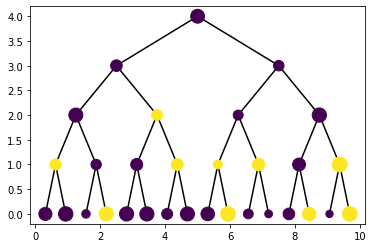

In [111]:
fig, ax = plt.subplots(1)
for link in tree['links']:
    ax.plot([link['x1'], link['x2']], [link['y1'], link['y2']], zorder = -1, c='black')
    
X = []
Y = []
R = []
C = []

for point in tree['points']:
    X.append(point['x'])
    Y.append(point['y'])
    R.append(20 * point['value'])
    C.append(point['variable'])
    

ax.scatter(X, Y, s=R, c=C)

# Leafs
file:///tmp/mozilla_ariel0/forests-10-00178.pdf
file:///tmp/mozilla_ariel0/symmetry-12-00645-v2.pdf

In [2]:
def gielis(phi, A, B, m, n1, n2, n3):
    term1 = np.cos((m * phi) / 4) / A
    term2 = np.sin((m * phi) / 4) / B
    return ((abs(term1) ** n2) + (abs(term2) ** n3)) ** (-1 / n1)

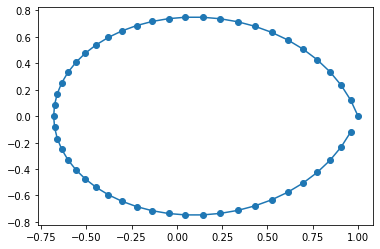

{'A': 1, 'B': 1, 'm': 1, 'n1': 0.9, 'n2': 1, 'n3': 1}


In [3]:
from numpy.random import random
fig, ax = plt.subplots(1)

kwargs = {
    'A': 1,
    'B': 1,
    'm': 1,
    'n1': 0.9,
    'n2': 1,
    'n3': 1,
}
delta_phi  = 2 * np.pi / 50
angles = np.arange(0, 2 * np.pi, delta_phi)

radiae = [gielis(phi, **kwargs) for phi in angles]

x = [r * np.cos(phi) for r, phi in zip(radiae, angles)]
y = [r * np.sin(phi) for r, phi in zip(radiae, angles)]

ax.plot(x, y, marker='o')
plt.show()
print(kwargs)

In [4]:
gielis_params = [
    {
        'A': 1,
        'B': 1,
        'm': 1,
        'n1': 1,
        'n2': 1,
        'n3': 1,
    },
    {
        'A': 2,
        'B': 1,
        'm': 2,
        'n1': 1,
        'n2': 2,
        'n3': 10,
    },
#     {
#         'A': 30,
#         'B': 1,
#         'm': 10,
#         'n1': 10,
#         'n2': -1,
#         'n3': 1,
#     },
    {
        'A': 2,
        'B': 2,
        'm': 2,
        'n1': 1,
        'n2': 2,
        'n3': 1,
    },
    {
        'A': 3,
        'B': 3,
        'm': 3,
        'n1': 3,
        'n2': 3,
        'n3': 3,
    },
]

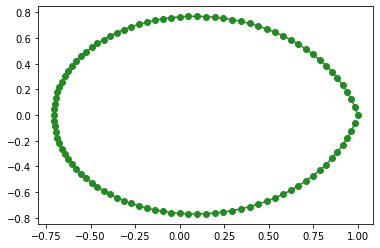

{'A': 1, 'B': 1, 'm': 1, 'n1': 1, 'n2': 1, 'n3': 1}


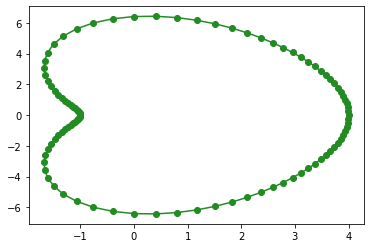

{'A': 2, 'B': 1, 'm': 2, 'n1': 1, 'n2': 2, 'n3': 10}


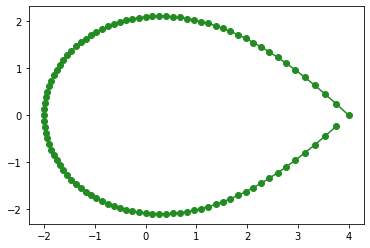

{'A': 2, 'B': 2, 'm': 2, 'n1': 1, 'n2': 2, 'n3': 1}


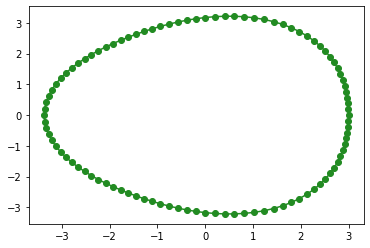

{'A': 3, 'B': 3, 'm': 3, 'n1': 3, 'n2': 3, 'n3': 3}


In [5]:
from numpy.random import random
for kwargs in gielis_params:
    fig, ax = plt.subplots(1)

    delta_phi  = 2 * np.pi / 100
    angles = np.arange(0, 2 * np.pi, delta_phi)

    radiae = [gielis(phi, **kwargs) for phi in angles]

    x = [r * np.cos(phi) for r, phi in zip(radiae, angles)]
    y = [r * np.sin(phi) for r, phi in zip(radiae, angles)]

    ax.plot(x, y, marker='o', color='forestgreen')
    plt.show()
    print(kwargs)